In [1]:
import numpy as np

import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as nnf
from torch.nn import MSELoss
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from torch.utils.data import Dataset

from torchvision.transforms import transforms
import torchvision.datasets as datasets

from torchinfo import summary

from utils.datasets import CIFAR_SR

from tqdm import tqdm

import matplotlib.pyplot as plt

from models.prediction.VAE import VAE

from utils.metrics import validation_scores

cuda = True
DEVICE = torch.device("cuda" if cuda and torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [2]:
path = "CIFAR_VAE_divers.pth"

x_dim = 32

scale_factor = 4
x_inp_dim  = int(x_dim / scale_factor)

# lr = 1e-3
epochs = 300
batch_size = 1024
batch_size_test = 128

train_dataset = CIFAR_SR(split="train", scale_factor=scale_factor)
test_dataset = CIFAR_SR(split="test", scale_factor=scale_factor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)

In [3]:
in_channels = 3
channels = [32, 64, 128, 256]
latent_dims = [80]

model = VAE(in_channels=in_channels, channels=channels, latent_dims=latent_dims, base_width=x_inp_dim).to(DEVICE)
summary(model, input_size=(1,in_channels, x_inp_dim, x_inp_dim))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [1, 3, 32, 32]            --
├─VAELREncoder: 1-1                      [1, 80]                   --
│    └─Conv2d: 2-1                       [1, 32, 8, 8]             128
│    └─Conv2d: 2-2                       [1, 64, 4, 4]             32,832
│    └─Conv2d: 2-3                       [1, 128, 2, 2]            131,200
│    └─Linear: 2-4                       [1, 80]                   41,040
│    └─Linear: 2-5                       [1, 80]                   41,040
├─VAEDecoder: 1-2                        [1, 3, 32, 32]            --
│    └─Linear: 2-6                       [1, 4096]                 331,776
│    └─ConvTranspose2d: 2-7              [1, 128, 8, 8]            524,416
│    └─ConvTranspose2d: 2-8              [1, 64, 16, 16]           131,136
│    └─ConvTranspose2d: 2-9              [1, 32, 32, 32]           32,800
│    └─Conv2d: 2-10                      [1, 3, 

In [ ]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = MSELoss()(x_hat, x)
    KLD = -0.5 * torch.mean(1+ log_var - mean.pow(2) - log_var.exp())
    return (reproduction_loss + 100*KLD) / x.size(0)

optimizer = Adam(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=10, gamma=0.9)

In [5]:
model_loss = []

In [6]:
print("Start training VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, batch in enumerate(train_loader):
        optimizer.zero_grad()
        HR, LR = batch

        SR, latents = model(LR)
        mean, log_var = latents[0]
        loss = loss_function(HR, SR, mean, log_var)

        overall_loss += loss.item()

        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print("\tEpoch", epoch, "complete!", "\tAverage Loss: ", overall_loss)

    model_loss.append(overall_loss)
    scheduler.step(overall_loss)

print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss)
print("Finish!!")

Start training VAE...
tensor(0.0627, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.0023, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0642, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.0023, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0630, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.0009, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0625, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.0006, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0625, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.0004, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0638, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.0003, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0626, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.0003, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0638, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0620, device='cuda:0', grad_fn=<MseLossBa

c:\Users\maxhe\anaconda3\envs\ML\Lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


tensor(0.0627, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(1.2248e-05, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0622, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(1.2218e-05, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0654, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(1.1678e-05, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0614, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(1.1404e-05, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0641, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(1.1372e-05, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0619, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(1.1314e-05, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0589, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(1.0310e-05, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0639, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(1.0688e-05, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0614, device='cuda:0', grad_fn=

[]

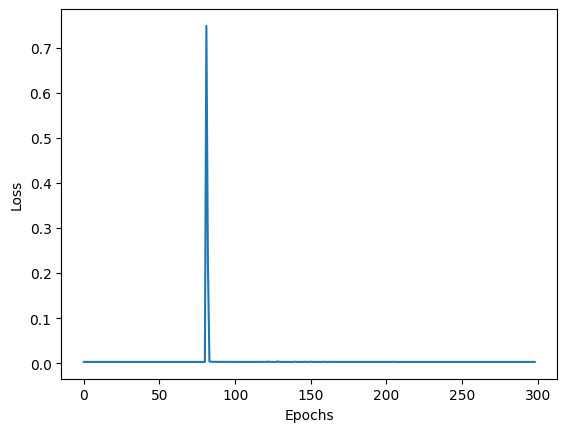

In [7]:
plt.plot(model_loss[1:])
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.yscale('log')
plt.plot()

In [8]:
HR, LR = test_dataset.get_samples(1000)
SR = model.sample(LR)

In [9]:
def show_image(x, low_res, superres, n):

    fig, axs = plt.subplots(3, n, figsize=(20, 6))
    for i in range(n):
        #figure description above every row in the middle
        if i == 0:
            axs[0, i].set_title('Original')
            axs[1, i].set_title('Low Resolution')
            axs[2, i].set_title('Super Resolution')

        axs[0, i].imshow(x[i].permute(1, 2, 0).detach().cpu().numpy(),)
        axs[0, i].axis('off')

        axs[1, i].imshow(low_res[i].permute(1, 2, 0).detach().cpu().numpy())
        axs[1, i].axis('off')

        axs[2, i].imshow(superres[i].permute(1, 2, 0).detach().cpu().numpy())
        axs[2, i].axis('off')

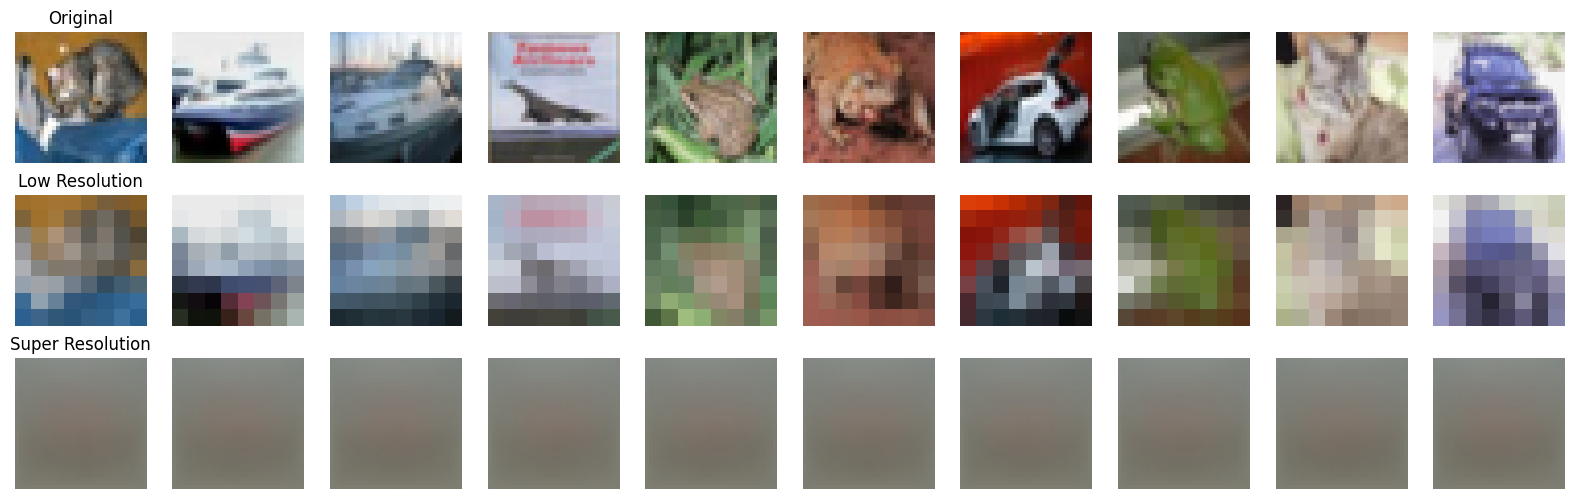

In [10]:
show_image(HR, LR, SR, 10)

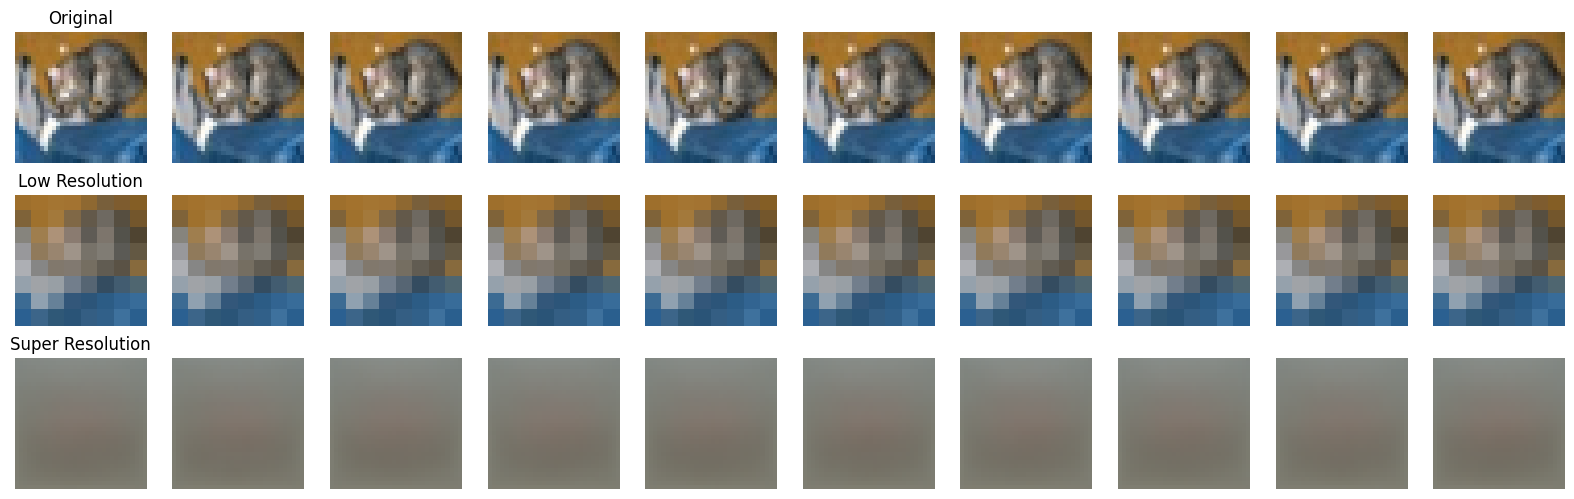

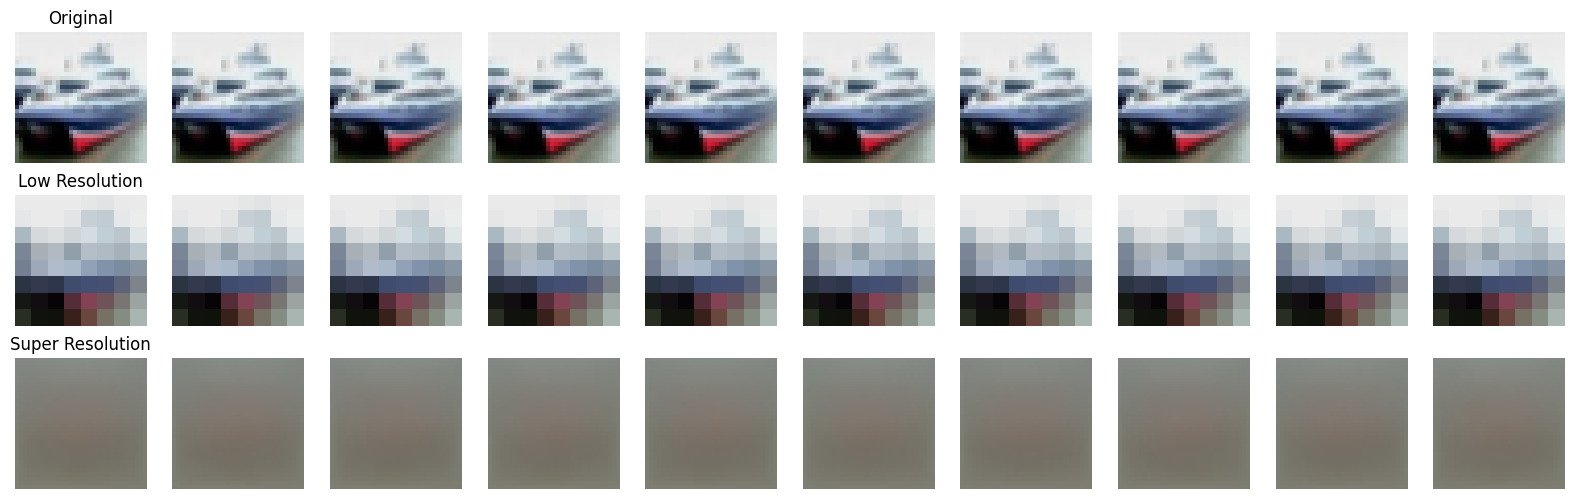

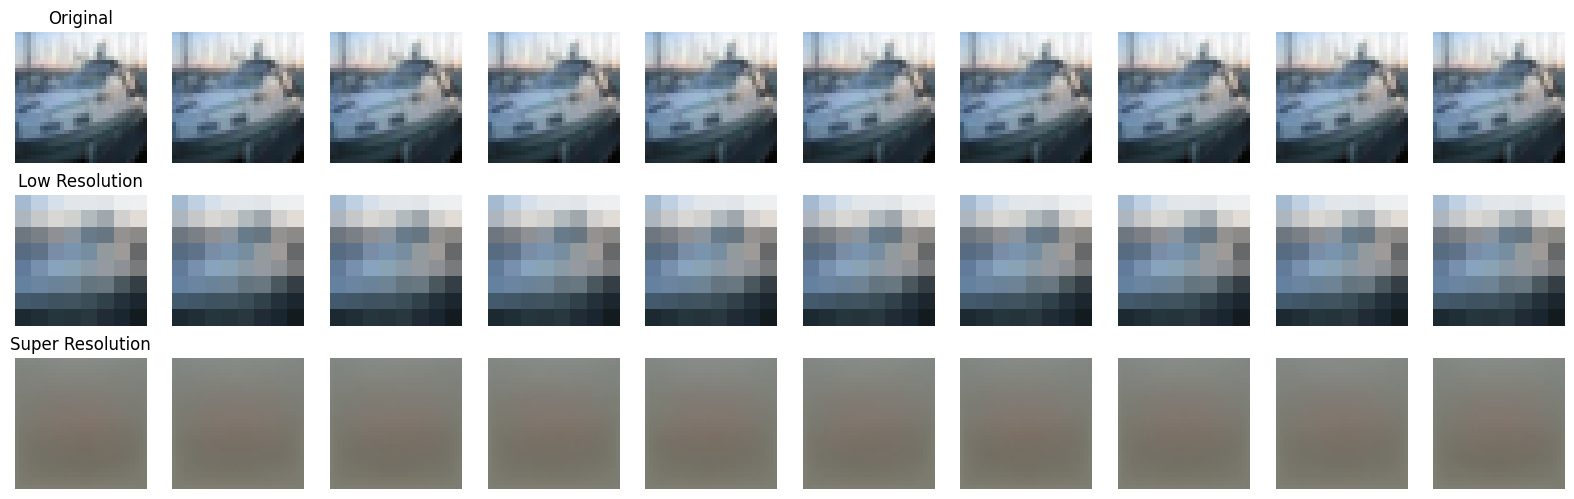

In [11]:
n_samp = 3

for i in range(n_samp):
    reference = HR[i]
    reference = reference.repeat(batch_size, 1, 1, 1)
    reference_inp = LR[i].unsqueeze(0).repeat(batch_size, 1, 1, 1)
    
    samples = model.sample(reference_inp).detach().cpu()

    show_image(reference, reference_inp, samples, 10)

In [12]:
# save model
torch.save(model.state_dict(), path)

In [13]:
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [14]:
mse_val, perceptual_val, psnr_val, ssim_val, lpips_val, brisque_val, psnr_consistency_val, mse_diversity_val, lpips_diversity_val = validation_scores(model, HR, LR)
print("MSE:", mse_val)
print("Perceptual:", perceptual_val)
print("PSNR:", psnr_val)
print("SSIM:", ssim_val)
print("LPIPS:", lpips_val)
print("BRISQUE:", brisque_val)
print("PSNR Consistency:", psnr_consistency_val)
print("MSE Diversity:", mse_diversity_val)
print("LPIPS Diversity:", lpips_diversity_val)

c:\Users\maxhe\anaconda3\envs\ML\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\maxhe\anaconda3\envs\ML\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MSE: 0.06137782707810402
Perceptual: 7.748101234436035
PSNR: 12.69892406463623
SSIM: 0.13452450931072235
LPIPS: 0.8234385251998901
BRISQUE: 48.43423843383789
PSNR Consistency: 14.16462230682373
MSE Diversity: 5.674854541837249e-06
LPIPS Diversity: 0.0070748927682871
